In [2]:
import numpy as np 
import pandas as pd 
import os
import json
import matplotlib.pyplot as plt
import scipy.stats
from tqdm import tqdm_notebook as tqdm
from collections import Counter
import spacy
import wordcloud

# load 
nlp = spacy.load('en_core_web_sm')

# needs to be changed for non-kaggle dirs
root_dir = os.getenv('HOME')
pdf_json_dir = f'{root_dir}/CORD-19-research-challenge/document_parses/pdf_json'
pmc_json_dir = f'{root_dir}/CORD-19-research-challenge/document_parses/pmc_json'
print(pdf_json_dir, '\n', pmc_json_dir)


/home/acabajar/CORD-19-research-challenge/document_parses/pdf_json 
 /home/acabajar/CORD-19-research-challenge/document_parses/pmc_json


## Exploring metadata

Looking at the head of metadata, we can see that there are some papers in `pdf_json` that are also in `pmc_json`. 

In [3]:
metadata = pd.read_csv(f'{root_dir}/CORD-19-research-challenge/metadata.csv')
metadata.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


`pdf_json` and `pmc_json` files have many nulls. Abstacts are also seen to contan numerous nulls.

In [4]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476776 entries, 0 to 476775
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cord_uid          476776 non-null  object 
 1   sha               157554 non-null  object 
 2   source_x          476776 non-null  object 
 3   title             476544 non-null  object 
 4   doi               262674 non-null  object 
 5   pmcid             166958 non-null  object 
 6   pubmed_id         229761 non-null  object 
 7   license           476776 non-null  object 
 8   abstract          344732 non-null  object 
 9   publish_time      476557 non-null  object 
 10  authors           463300 non-null  object 
 11  journal           445028 non-null  object 
 12  mag_id            0 non-null       float64
 13  who_covidence_id  196150 non-null  object 
 14  arxiv_id          6269 non-null    object 
 15  pdf_json_files    157554 non-null  object 
 16  pmc_json_files    12

In [5]:
def lower_case_lemmas(doc):
    for token in doc :
        token.lemma_ = token.lemma_.lower()
    return doc

nlp.add_pipe(lower_case_lemmas, name = 'lower_case_lemmas', after = 'tagger') 

def get_tokens(docs, unlist = True):
    docs_token_list = []
    for _doc in tqdm(nlp.pipe(docs, disable = ['tagger', 'parser'])):
        tokens = [token.lemma_ for token in _doc if not token.is_stop | token.is_space | token.is_punct]
        docs_token_list.append(tokens)
    
    if unlist:
        # unlist the docs token list
        docs_token_list_ = [tok for tokens in docs_token_list for tok in tokens]
        return docs_token_list_
    else:
        return docs_token_list

def plot_top_n_words(docs_token_list, top_n = 10, figsize = (10, 8), return_counter = False):
    word_freq = Counter(docs_token_list)
    most_freq_words = word_freq.most_common(top_n)
    most_freq_words_df = pd.DataFrame(most_freq_words, columns = ['word', 'count']) 
    fig, ax = plt.subplots(1, figsize = figsize)
    ax.set_title(f'Top {top_n} most frequent words in title')
    most_freq_words_df.plot.barh('word', 'count', ax = ax)
    
    if return_counter:
        return word_freq
    
    plt.show()
    
    

### running the NLP pipeline on the whole set of titles

We try and investigate the whole set of titles and see if there are some things that we should take into account.

In [6]:
all_titles = metadata.title
all_titles = all_titles.loc[~all_titles.isnull()]
docs_token_list_all = get_tokens(all_titles)

0it [00:00, ?it/s]

In this simple enumeration of word frequencies, we can see that there are some words that are clearly not english such as *la* and *de*.

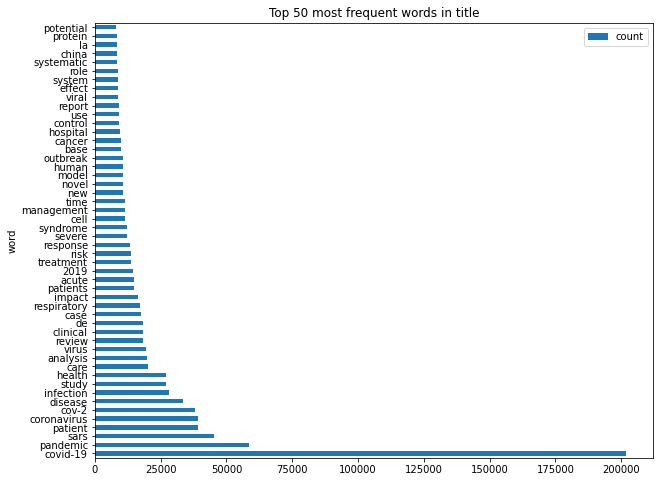

In [7]:
counter_all = plot_top_n_words(docs_token_list_all, top_n = 50, return_counter = True)

Shown below is a word cloud for the most frequent words in the corpus of article titles.

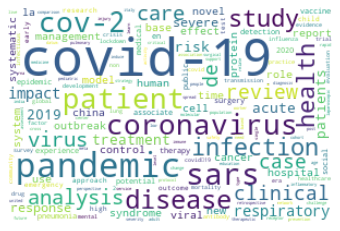

In [12]:
wc_obj = wordcloud.WordCloud(background_color = None, mode = 'RGBA', 
                             width = 300, height = 200)
#fig = plt.figure(figsize = (8,6))
wc = wc_obj.generate_from_frequencies(counter_all)
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

## Exploring a single document

Try opening one file

In [119]:
docs = os.listdir(pdf_json_dir)
doc1 = f'{pdf_json_dir}/{docs[0]}'

with open(doc1) as f:
    doc = json.load(f)

In [120]:
keys_list = list(doc.keys())

for k in keys_list:
    print(k, type(doc[k]))

paper_id <class 'str'>
metadata <class 'dict'>
abstract <class 'list'>
body_text <class 'list'>
bib_entries <class 'dict'>
ref_entries <class 'dict'>
back_matter <class 'list'>


Investigate body text

In [121]:
for i in doc['body_text']:
    print(type(i), i.keys())
    print(i['section'], '\nlength of text:', len(i['text']), '\n', i['text'], '\n\n')
    

<class 'dict'> dict_keys(['text', 'cite_spans', 'ref_spans', 'section'])
COVID-19-negative psychiatric units: Mitigating sequelae of pandemic isolation 
length of text: 30 
 Research Letter to the Editor: 


<class 'dict'> dict_keys(['text', 'cite_spans', 'ref_spans', 'section'])
COVID-19-negative psychiatric units: Mitigating sequelae of pandemic isolation 
length of text: 904 
 We are writing to call attention to the profound psychological/ physiological stress caused by the ongoing coronavirus disease 2019 (COVID-19) pandemic. As second waves are on the rise, U.S. total death rates related to COVID-19 are greater than 270,000, and above 1.5 million worldwide [1] . While public health guidelines continue to advise social distancing to prevent further spread of the virus, this very distancing increases pandemic-induced isolation, fear of infection, and fear of death [2] [3] [4] [5] [6] [7] [8] . Extended periods of social isolation have led to disruption of daily routines, separation 

get body text total length for `pdf_json`

In [122]:
def get_body_text(path_to_doc):
    with open(path_to_doc) as f:
        js = json.load(f)
    
    return js['body_text']

In [123]:
def get_total_lengths(dir, total_num_docs = None):
    # get total list of docs
    docs = os.listdir(dir)
    
    doc_lengths = []
    for i, doc in tqdm(enumerate(docs)):
        # get full directory of json file
        if total_num_docs is None:
            pass
        else:
            if i >= total_num_docs:
                return doc_lengths

        full_path = f'{dir}/{doc}'
        with open(full_path) as f:
            js = json.load(f)
            doc_len = 0
            for t in js['body_text']:
                doc_len += len(t['text'])
            doc_lengths.append(doc_len)

    return doc_lengths

lengths_pdf = get_total_lengths(pdf_json_dir)
                

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


|          | 0/? [00:00<?, ?it/s]

In [124]:
lengths_pmc = get_total_lengths(pmc_json_dir)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


|          | 0/? [00:00<?, ?it/s]

PDF lengths
 count    1.634920e+05
mean     2.465823e+04
std      4.598500e+04
min      1.000000e+00
25%      9.532000e+03
50%      1.878000e+04
75%      2.987900e+04
max      6.009611e+06
dtype: float64 

PMC lengths
 count    1.238780e+05
mean     2.251141e+04
std      3.032532e+04
min      1.000000e+00
25%      9.407000e+03
50%      1.871250e+04
75%      2.922475e+04
max      4.091568e+06
dtype: float64


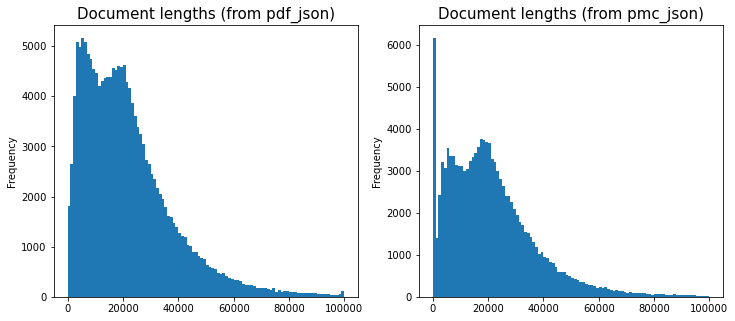

In [125]:
lengths_pdf_s = pd.Series(lengths_pdf)
lengths_pmc_s = pd.Series(lengths_pmc)
print('PDF lengths\n', lengths_pdf_s.describe(), '\n')
print('PMC lengths\n', lengths_pmc_s.describe())
fig, ax = plt.subplots(1,2, figsize = (12,5))

# remove "outliers" using 1.5 * IQR from 75th quartile
outlier_boundary = 1.5 * scipy.stats.iqr(np.array(lengths_pdf))
p75 = np.quantile(lengths_pdf, 0.75)

lengths_pdf_s_new = lengths_pdf_s.loc[lengths_pdf_s <= 1e5]
lengths_pmc_s_new = lengths_pmc_s.loc[lengths_pmc_s <= 1e5]

lengths_pdf_s_new.plot(kind = 'hist', bins= 100, ax = ax[0])
lengths_pmc_s_new.plot(kind = 'hist', bins = 100, ax = ax[1])
ax[0].set_title('Document lengths (from pdf_json)', size = 15)
ax[1].set_title('Document lengths (from pmc_json)', size = 15)
plt.show()

Investigating documents that are greater than $1\times10^{-6}$. Most documents are a group of abstracts or vignettes for a congress/conference.

In [126]:
doc_idx = lengths_pdf_s.loc[lengths_pdf_s > 1e6].index
sha_list = [docs[i].replace('.json', '') for i in doc_idx]
metadata.loc[metadata.sha.isin(sha_list)][['title', 'sha']].title.tolist()

['Clinical Vignettes',
 'Abstracts from the 11th International Congress of Behavioral Medicine',
 'ESP Abstracts 2012',
 'Oral and Poster Manuscripts',
 'Atti del 52° Congresso Nazionale: Società Italiana di Igiene, Medicina Preventiva e Sanità Pubblica (SItI)',
 'ADOLESCENT MEDICINE',
 'Abstracts for MASCC/ISOO Annual Meeting 2019',
 'Ninth Meeting of the European Neurological Society 5–9 June, 1999, Milan, Italy: Abstracts of Symposia, Free Communications and Posters',
 'Health—exploring complexity: an interdisciplinary systems approach HEC2016: 28 August–2 September 2016, Munich, Germany',
 'Abstracts of the MASCC/ISOO Annual Meeting 2018',
 'Abstracts of the 14th International Congress of the European Geriatric Medicine Society: 10–12 October 2018, Berlin, Germany',
 'Physicians Poster Sessions',
 'The 45th Annual Meeting of the European Society for Blood and Marrow Transplantation: Physicians – Poster Session',
 'Physicians – Poster Session',
 '8th European Congress of Intensive C